# Bug related to data type of chirp_time

This NB explores a bug I found when trying to slice then plot `chirp`. The bug only appears when you try to slice with more than one `chirp_num`. The issue is that all the saved zarrs from the Greenland lakes data have  ds.chirp_time.dtype = timedelta64[ns] and this doesnt seem to play nicely with xarray's plotting reliably. 

In [2]:
import sys
sys.path.append("../../../xapres_package/")
import xapres_package as xa

In [11]:
from_zarr = xa.load.load_zarr()
from_zarr

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11723,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

This works:

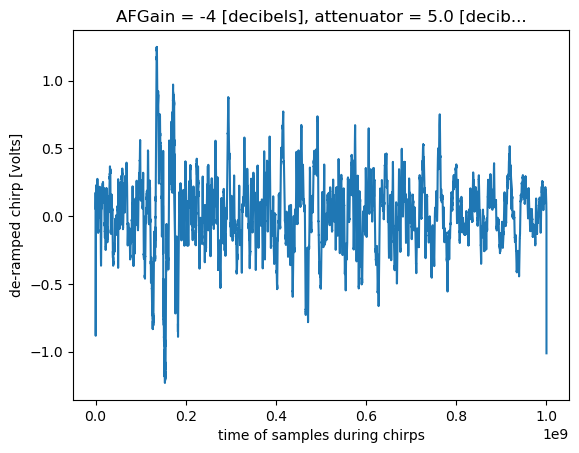

In [4]:
from_zarr.chirp.isel(time=100, chirp_num=10, attenuator_setting_pair=0).plot()

..but something about trying to plot multiple chirps causes this to fail with

```
TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[timedelta64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>)
```

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[timedelta64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>)

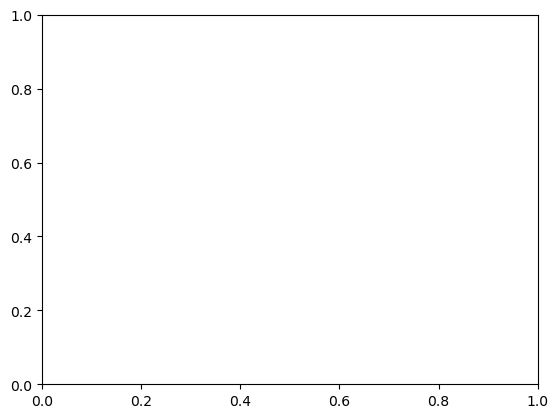

In [5]:
from_zarr.chirp.isel(time=100, chirp_num=10).plot()

It also fails when you slice it in a different way. 

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[timedelta64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>)

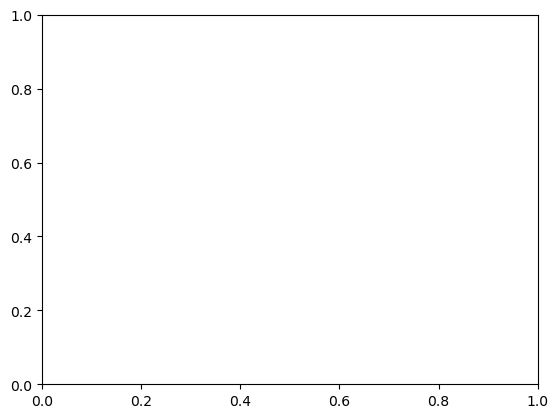

In [6]:
from_zarr.chirp.isel(time=100, attenuator_setting_pair=0).plot()

The issue is becuase the chirp_time dimension being a dtype of timedelta64[ns]:

In [21]:
from_zarr.chirp_time.values.dtype

dtype('<m8[ns]')

we know this is a critical issue because replacing the values with floats fixes the bug and we are able to plot a multi-dimensional array

In [22]:
from_zarr['chirp_time'] = from_zarr.chirp_time.values.astype("float64")

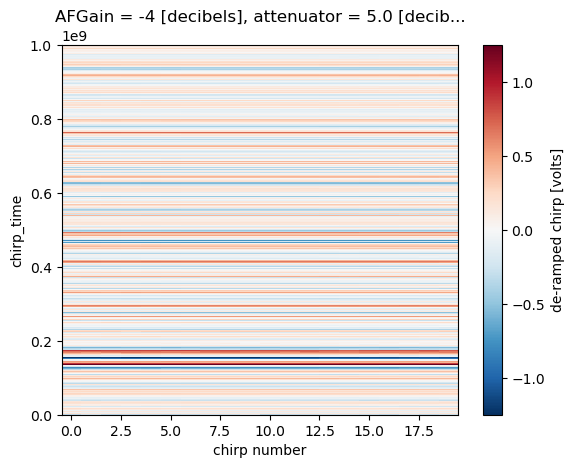

In [23]:
from_zarr.chirp.isel(time=100, attenuator_setting_pair=0).plot()

let's see if `generate_xarray` makes chirp_time a timedelta64[ns]

In [19]:
from_DAT_unattended = xa.load.generate_xarray(directory='../../data/sample/single_dat_file/', 
            file_numbers_to_process = [0], 
            bursts_to_process=[0],
            )
from_DAT_unattended.chirp_time.dtype

dtype('float64')

It is not, it is a float64 and we are able to plot as required. 

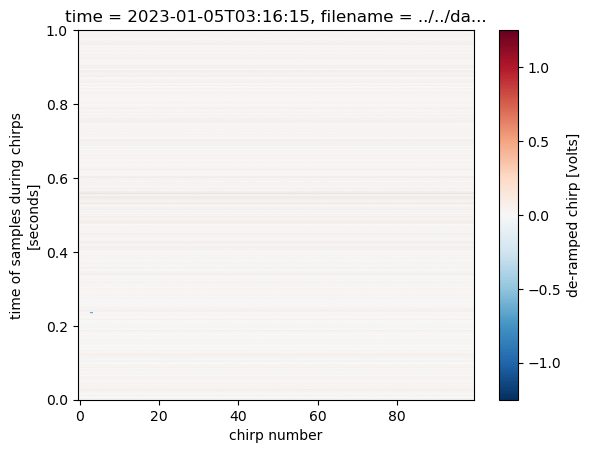

In [26]:
from_DAT_unattended.chirp.isel(time=0, attenuator_setting_pair=0).plot()

...so where does it become a timedelta64[ns]? It doesn't appear to be in the NBs we used to save the zarrs (Documents/science/ApRES/xapres_package/notebooks/to_zarr/to_individual_zarr.ipynb and 

## Testing other slicing
Test out slicing along other dimensions in the original dataset we get from `from_zarr`:

In [ ]:
from_zarr_2 = xa.load.load_zarr()

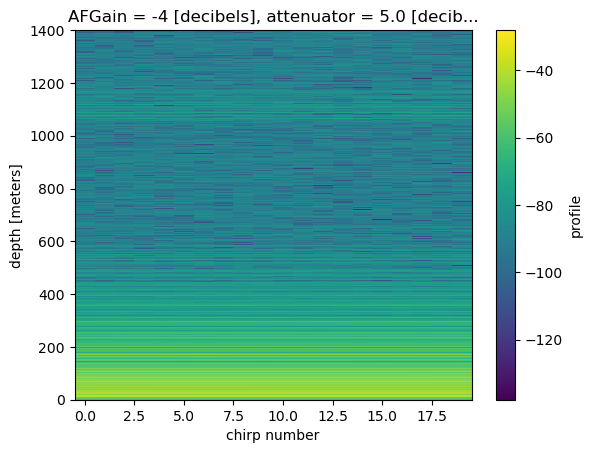

In [33]:
# the same slicing as above, but with profile, instead of chirp, works!
sliced_1 = from_zarr_2.profile.isel(time=100, attenuator_setting_pair=0).dB().plot()

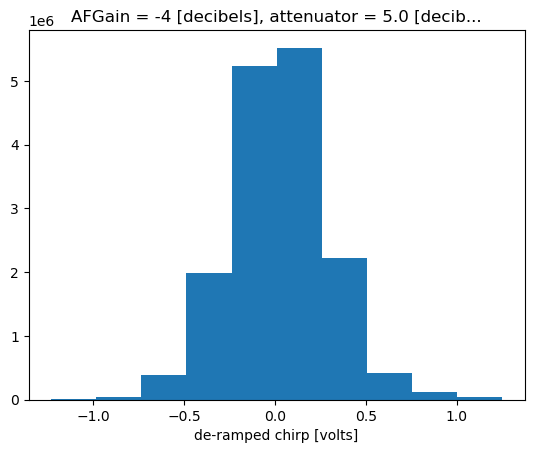

In [34]:
# slicing chirp along time and attenuator_setting_pair, leaving a 3D dataarray 
from_zarr_2.chirp.isel(time=slice(80,100,1), attenuator_setting_pair=0).plot()

TypeError: The DType <class 'numpy.dtype[timedelta64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[timedelta64]'>, <class 'numpy.dtype[float64]'>)

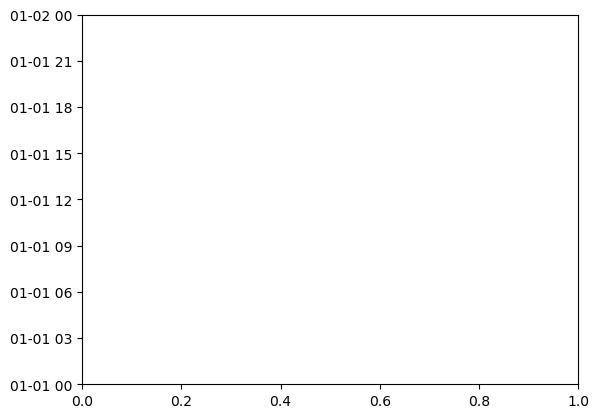

In [37]:
# slicing chirp along time, chirp_num, and attenuator_setting_pair, leaving a differnt 2D dataarray than before
from_zarr_2.chirp.isel(time=slice(80,100,1), chirp_num = 10, attenuator_setting_pair=0).plot()
# this does not work

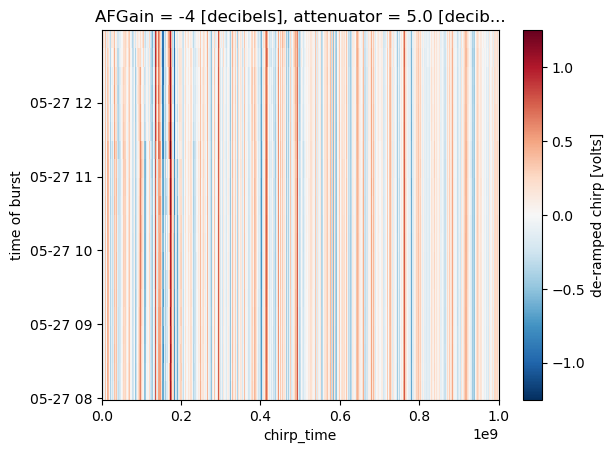

In [38]:
# try using the version with the chirp_time replaced with floats
from_zarr.chirp.isel(time=slice(80,100,1), chirp_num = 10, attenuator_setting_pair=0).plot()
# this one works. 

## Test other datasets from the Greenland lakes project

In [42]:
from_zarr_A103 = xa.load.load_zarr(directory = "gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/A103")

In [43]:
from_zarr_A103

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11763,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-02-17T16:37:49 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

In [45]:
from_zarr_A104 = xa.load.load_zarr(directory = "gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/A104")
from_zarr_A104.chirp_time.dtype

dtype('<m8[ns]')

In [46]:
from_zarr_A103_fixed = xa.load.load_zarr(directory = "gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/A103_fixed")
from_zarr_A103_fixed.chirp_time.dtype

dtype('<m8[ns]')

In [47]:
from_zarr_A101_winter22_23 = xa.load.load_zarr(directory = "gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/A101_winter22_23")
from_zarr_A101_winter22_23.chirp_time.dtype

dtype('<m8[ns]')

In [56]:
from_zarr_A104_winter22_23 = xa.load.load_zarr(directory = "gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/A104_winter22_23")
from_zarr_A104_winter22_23.chirp_time.dtype

dtype('<m8[ns]')

In [47]:
from_zarr_A101_winter22_23 = xa.load.load_zarr(directory = "gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/A101_winter22_23")
from_zarr_A101_winter22_23.chirp_time.dtype

dtype('<m8[ns]')

It looks like all the zarrs saved in the google bucket have this dtype for `chirp_time`.